<a id='header'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for data sampling

In this notebook we present the sampling functionalities from the `preprocess` module.

### Sampling

A synthetic data set is created and we perform train and test data sampling using available functions from the `DataSampler` class:

- [**Section 1**](#select_fixed_number): Fixed number of samples from each cluster (`DataSampler.number`)
- [**Section 2**](#select_fixed_percentage): Percentage of samples from each cluster (`DataSampler.percentage`)
- [**Section 3**](#select_manually): Manual sampling (`DataSampler.manual`)
- [**Section 4**](#select_at_random): Random sampling (`DataSampler.random`)

For each function we present visually how test data can be sampled using the available `test_selection_option` parameter.

[**Section 5**](#maintain_fixed_test_data): We present a use-case for maintaining fixed test data samples using the `idx_test` parameter.

[**Section 6**](#chaining_sampling_functions): We show how two sampling functions can be combined where train samples from one sampling become fixed test data for another sampling.

***

**Should plots be saved?**

In [1]:
save_plots = False

***

In [14]:
from PCAfold import DataSampler
from PCAfold import preprocess
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

save_filename = None
color_map = ListedColormap(['#0e7da7', '#ceca70', '#b45050', '#2d2d54'])
first_cluster = False
figure_size = (5,5)
random_seed = 200
np.random.seed(seed=random_seed)

Generate data set that has four distinct clusters with imbalanced number of samples in each cluster:

In [15]:
N_1, N_2, N_3, N_4 = 100, 250, 400, 500
n_observations = N_1 + N_2 + N_3 + N_4
mean_k1, mean_k2, mean_k3, mean_k4 = [-3, 3], [3, 3], [-3, -3], [3, -3] 
covariance = [[1, 0.2], [0.2, 1]]
x_k1, y_k1 = np.random.multivariate_normal(mean_k1, covariance, N_1).T
x_k2, y_k2 = np.random.multivariate_normal(mean_k2, covariance, N_2).T
x_k3, y_k3 = np.random.multivariate_normal(mean_k3, covariance, N_3).T
x_k4, y_k4 = np.random.multivariate_normal(mean_k4, covariance, N_4).T
x = np.vstack((x_k1[:,np.newaxis], x_k2[:,np.newaxis], x_k3[:,np.newaxis], x_k4[:,np.newaxis]))
y = np.vstack((y_k1[:,np.newaxis], y_k2[:,np.newaxis], y_k3[:,np.newaxis], y_k4[:,np.newaxis]))
idx = np.vstack((np.zeros((N_1, 1)), np.ones((N_2, 1)), 2*np.ones((N_3, 1)), 3*np.ones((N_4, 1)))).astype(int).ravel()
populations = preprocess.get_populations(idx)

Plot the original data set:

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

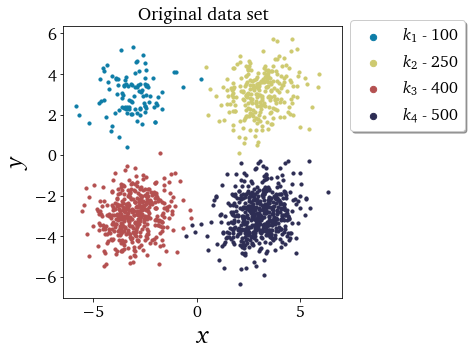

In [16]:
if save_plots: save_filename = '../images/tutorial-train-test-select-original-data-set.svg'
preprocess.plot_2d_clustering(x, y, idx, x_label='$x$', y_label='$y$', color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=figure_size, title='Original data set', save_filename=save_filename)

Initialize the `DataSampler` class object:

In [5]:
sample = DataSampler(idx, idx_test=[], random_seed=random_seed, verbose=True)

***
<a id='select_fixed_number'></a>
## Select fixed number

[**Go up**](#header)

Using `test_selection_option=1`:

Cluster 0: taking 46 train samples out of 100 observations (46.0%).
Cluster 1: taking 46 train samples out of 250 observations (18.4%).
Cluster 2: taking 46 train samples out of 400 observations (11.5%).
Cluster 3: taking 46 train samples out of 500 observations (9.2%).

Cluster 0: taking 54 test samples out of 54 remaining observations (100.0%).
Cluster 1: taking 204 test samples out of 204 remaining observations (100.0%).
Cluster 2: taking 354 test samples out of 354 remaining observations (100.0%).
Cluster 3: taking 454 test samples out of 454 remaining observations (100.0%).

Selected 184 train samples (14.7%) and 1066 test samples (85.3%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

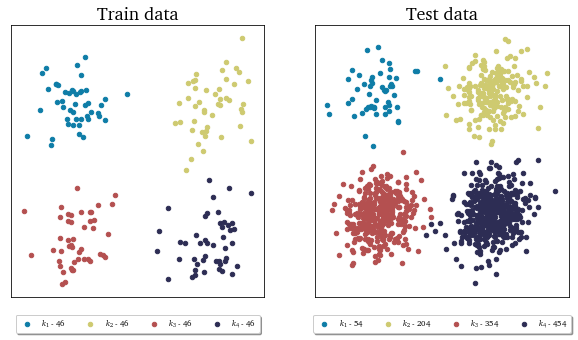

In [6]:
(idx_train, idx_test) = sample.number(15, test_selection_option=1)
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-number-1.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Using `test_selection_option=2`:

Cluster 0: taking 46 train samples out of 100 observations (46.0%).
Cluster 1: taking 46 train samples out of 250 observations (18.4%).
Cluster 2: taking 46 train samples out of 400 observations (11.5%).
Cluster 3: taking 46 train samples out of 500 observations (9.2%).

Cluster 0: taking 54 test samples out of 54 remaining observations (100.0%).
Cluster 1: taking 54 test samples out of 204 remaining observations (26.5%).
Cluster 2: taking 54 test samples out of 354 remaining observations (15.3%).
Cluster 3: taking 54 test samples out of 454 remaining observations (11.9%).

Selected 184 train samples (14.7%) and 216 test samples (17.3%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

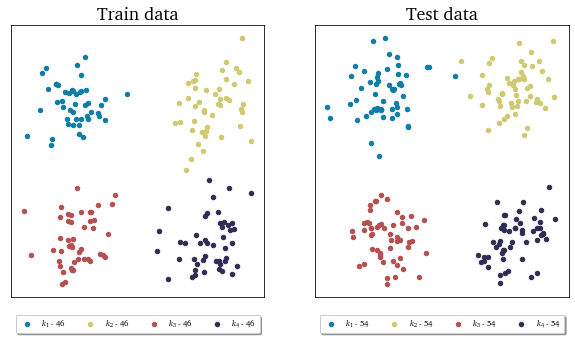

In [7]:
(idx_train, idx_test) = sample.number(15, test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-number-2.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='select_fixed_percentage'></a>
## Select fixed percentage

[**Go up**](#header)

Using `test_selection_option=1`:

Cluster 0: taking 10 train samples out of 100 observations (10.0%).
Cluster 1: taking 25 train samples out of 250 observations (10.0%).
Cluster 2: taking 40 train samples out of 400 observations (10.0%).
Cluster 3: taking 50 train samples out of 500 observations (10.0%).

Cluster 0: taking 90 test samples out of 90 remaining observations (100.0%).
Cluster 1: taking 225 test samples out of 225 remaining observations (100.0%).
Cluster 2: taking 360 test samples out of 360 remaining observations (100.0%).
Cluster 3: taking 450 test samples out of 450 remaining observations (100.0%).

Selected 125 train samples (10.0%) and 1125 test samples (90.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

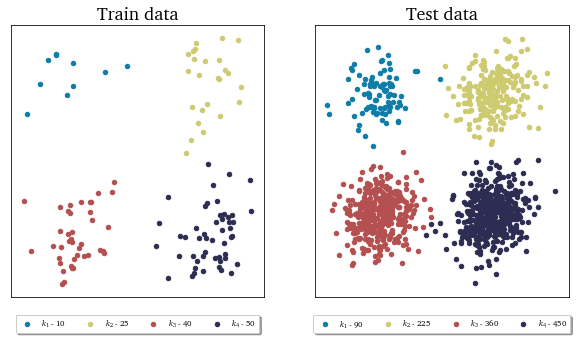

In [8]:
(idx_train, idx_test) = sample.percentage(10, test_selection_option=1)
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-percentage-1.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Using `test_selection_option=2`:

Cluster 0: taking 10 train samples out of 100 observations (10.0%).
Cluster 1: taking 25 train samples out of 250 observations (10.0%).
Cluster 2: taking 40 train samples out of 400 observations (10.0%).
Cluster 3: taking 50 train samples out of 500 observations (10.0%).

Cluster 0: taking 10 test samples out of 90 remaining observations (11.1%).
Cluster 1: taking 25 test samples out of 225 remaining observations (11.1%).
Cluster 2: taking 40 test samples out of 360 remaining observations (11.1%).
Cluster 3: taking 50 test samples out of 450 remaining observations (11.1%).

Selected 125 train samples (10.0%) and 125 test samples (10.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

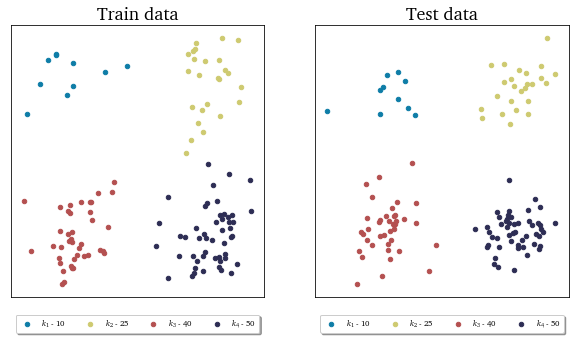

In [9]:
(idx_train, idx_test) = sample.percentage(10, test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-fixed-percentage-2.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='select_manually'></a>
## Select manually

[**Go up**](#header)

Using `test_selection_option=1`:

Cluster 0: taking 4 train samples out of 100 observations (4.0%).
Cluster 1: taking 5 train samples out of 250 observations (2.0%).
Cluster 2: taking 10 train samples out of 400 observations (2.5%).
Cluster 3: taking 2 train samples out of 500 observations (0.4%).

Cluster 0: taking 96 test samples out of 96 remaining observations (100.0%).
Cluster 1: taking 245 test samples out of 245 remaining observations (100.0%).
Cluster 2: taking 390 test samples out of 390 remaining observations (100.0%).
Cluster 3: taking 498 test samples out of 498 remaining observations (100.0%).

Selected 21 train samples (1.7%) and 1229 test samples (98.3%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

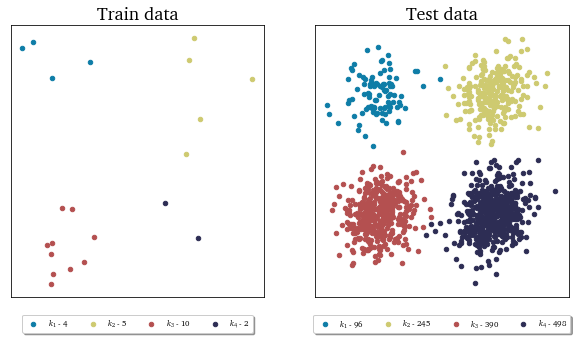

In [10]:
(idx_train, idx_test) = sample.manual({0:4, 1:5, 2:10, 3:2}, sampling_type='number', test_selection_option=1)
if save_plots: save_filename = '../images/tutorial-train-test-select-manually-1.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Using `test_selection_option=2`:

Cluster 0: taking 50 train samples out of 100 observations (50.0%).
Cluster 1: taking 25 train samples out of 250 observations (10.0%).
Cluster 2: taking 40 train samples out of 400 observations (10.0%).
Cluster 3: taking 100 train samples out of 500 observations (20.0%).

Cluster 0: taking 50 test samples out of 50 remaining observations (100.0%).
Cluster 1: taking 25 test samples out of 225 remaining observations (11.1%).
Cluster 2: taking 40 test samples out of 360 remaining observations (11.1%).
Cluster 3: taking 100 test samples out of 400 remaining observations (25.0%).

Selected 215 train samples (17.2%) and 215 test samples (17.2%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

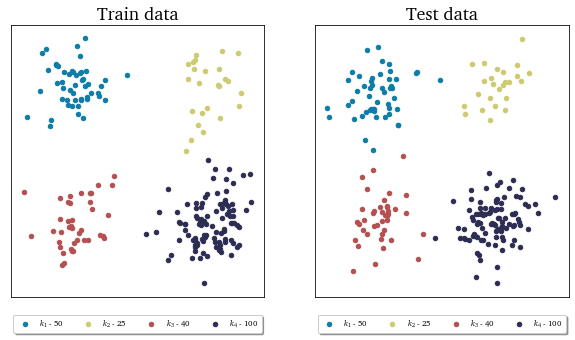

In [11]:
(idx_train, idx_test) = sample.manual({0:50, 1:10, 2:10, 3:20}, sampling_type='percentage', test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-manually-2.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='select_at_random'></a>
## Select at random

[**Go up**](#header)

Using `test_selection_option=1`:

Cluster 0: taking 14 train samples out of 100 observations (14.0%).
Cluster 1: taking 28 train samples out of 250 observations (11.2%).
Cluster 2: taking 42 train samples out of 400 observations (10.5%).
Cluster 3: taking 41 train samples out of 500 observations (8.2%).

Cluster 0: taking 86 test samples out of 86 remaining observations (100.0%).
Cluster 1: taking 222 test samples out of 222 remaining observations (100.0%).
Cluster 2: taking 358 test samples out of 358 remaining observations (100.0%).
Cluster 3: taking 459 test samples out of 459 remaining observations (100.0%).

Selected 125 train samples (10.0%) and 1125 test samples (90.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

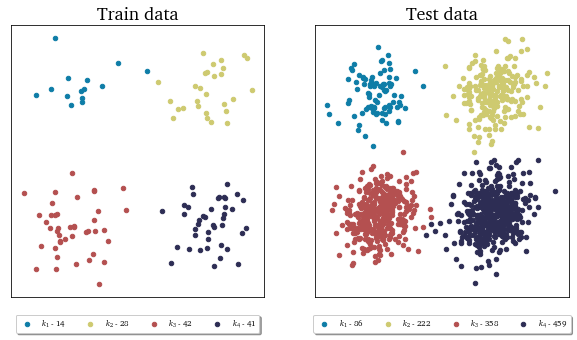

In [12]:
(idx_train, idx_test) = sample.random(10, test_selection_option=1)
if save_plots: save_filename = '../images/tutorial-train-test-select-random-doc-1.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5),save_filename=save_filename)

Using `test_selection_option=2`:

Cluster 0: taking 14 train samples out of 100 observations (14.0%).
Cluster 1: taking 28 train samples out of 250 observations (11.2%).
Cluster 2: taking 42 train samples out of 400 observations (10.5%).
Cluster 3: taking 41 train samples out of 500 observations (8.2%).

Cluster 0: taking 8 test samples out of 86 remaining observations (9.3%).
Cluster 1: taking 25 test samples out of 222 remaining observations (11.3%).
Cluster 2: taking 29 test samples out of 358 remaining observations (8.1%).
Cluster 3: taking 63 test samples out of 459 remaining observations (13.7%).

Selected 125 train samples (10.0%) and 125 test samples (10.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

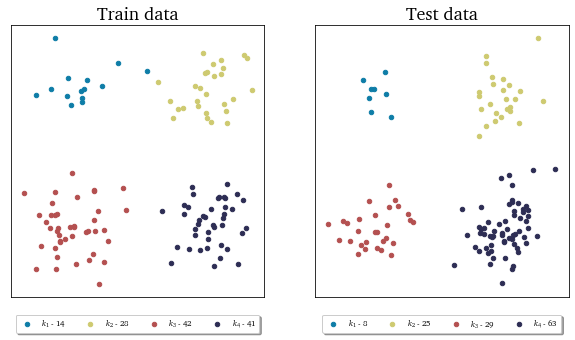

In [13]:
(idx_train, idx_test) = sample.random(10, test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-random-doc-2.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='maintain_fixed_test_data'></a>
## Maintain fixed test data

[**Go up**](#header)

In the example below we further illustrate how the `idx_test` input parameter can be utilized when initializing `DataSampler` class.
For that purpose we append the data set with additional samples. The additional samples simulate a real use-case where you have a very specific test set that you would like to maintain.

We demonstrate this using each sampling function.

In [14]:
Nt_1, Nt_2, Nt_3, Nt_4 = 20, 20, 20, 20
mean_k1, mean_k2, mean_k3, mean_k4 = [-7, 7], [7, 7], [-7, -7], [7, -7]
covariance = [[0.2, .1], [.1, 0.2]]
xt_k1, yt_k1 = np.random.multivariate_normal(mean_k1, covariance, Nt_1).T
xt_k2, yt_k2 = np.random.multivariate_normal(mean_k2, covariance, Nt_2).T
xt_k3, yt_k3 = np.random.multivariate_normal(mean_k3, covariance, Nt_3).T
xt_k4, yt_k4 = np.random.multivariate_normal(mean_k4, covariance, Nt_4).T
xt = np.vstack((xt_k1[:,np.newaxis], xt_k2[:,np.newaxis], xt_k3[:,np.newaxis], xt_k4[:,np.newaxis], x))
yt = np.vstack((yt_k1[:,np.newaxis], yt_k2[:,np.newaxis], yt_k3[:,np.newaxis], yt_k4[:,np.newaxis], y))
idx_appended = np.vstack((np.zeros((Nt_1, 1)), np.ones((Nt_2, 1)), 2*np.ones((Nt_3, 1)), 3*np.ones((Nt_4, 1)), np.zeros((N_1, 1)), np.ones((N_2, 1)), 2*np.ones((N_3, 1)), 3*np.ones((N_4, 1)))).astype(int).ravel()
idx_test = np.arange(0,Nt_1+Nt_2+Nt_3+Nt_4,1)
populations = preprocess.get_populations(idx_appended)

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

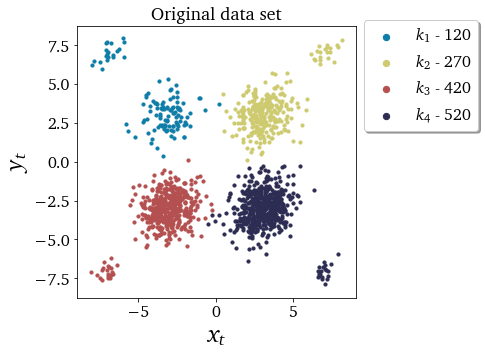

In [15]:
if save_plots: save_filename = '../images/tutorial-train-test-select-original-data-set-appended-doc.svg'
preprocess.plot_2d_clustering(xt, yt, idx_appended, x_label="$x_t$", y_label="$y_t$", color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=figure_size, title='Original data set', save_filename=save_filename)

Initialize the `DataSampler` class object using `idx_test` as an input parameter:

In [16]:
sample = DataSampler(idx_appended, idx_test=idx_test, random_seed=random_seed, verbose=True)

User defined test samples will be used. Parameter `test_selection_option` will be ignored.



Select samples using each of the sampling functions (note that `test_selection_option` will be ignored in each case when `idx_test` parameter is used):

Cluster 0: taking 33 train samples out of 120 observations (27.5%).
Cluster 1: taking 33 train samples out of 270 observations (12.2%).
Cluster 2: taking 33 train samples out of 420 observations (7.9%).
Cluster 3: taking 33 train samples out of 520 observations (6.3%).

Cluster 0: taking 20 test samples out of 87 remaining observations (23.0%).
Cluster 1: taking 20 test samples out of 237 remaining observations (8.4%).
Cluster 2: taking 20 test samples out of 387 remaining observations (5.2%).
Cluster 3: taking 20 test samples out of 487 remaining observations (4.1%).

Selected 132 train samples (9.9%) and 80 test samples (6.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

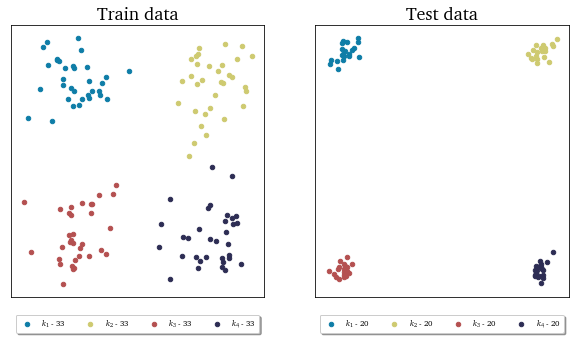

In [17]:
(idx_train, idx_test) = sample.number(10, test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-number-with-idx-test.svg'
preprocess.plot_2d_train_test_samples(xt, yt, idx_appended, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Cluster 0: taking 12 train samples out of 120 observations (10.0%).
Cluster 1: taking 27 train samples out of 270 observations (10.0%).
Cluster 2: taking 42 train samples out of 420 observations (10.0%).
Cluster 3: taking 52 train samples out of 520 observations (10.0%).

Cluster 0: taking 20 test samples out of 108 remaining observations (18.5%).
Cluster 1: taking 20 test samples out of 243 remaining observations (8.2%).
Cluster 2: taking 20 test samples out of 378 remaining observations (5.3%).
Cluster 3: taking 20 test samples out of 468 remaining observations (4.3%).

Selected 133 train samples (10.0%) and 80 test samples (6.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

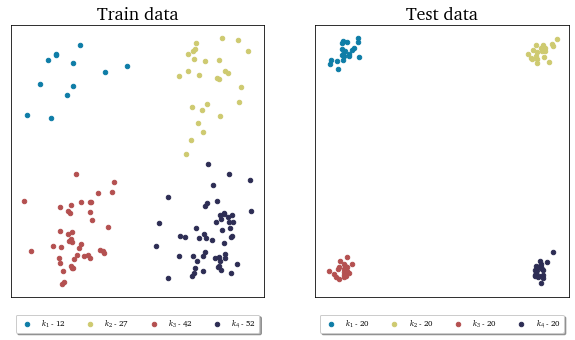

In [18]:
(idx_train, idx_test) = sample.percentage(10, test_selection_option=2)
if save_plots==True: save_filename = '../images/tutorial-train-test-select-percentage-with-idx-test.svg'
preprocess.plot_2d_train_test_samples(xt, yt, idx_appended, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Cluster 0: taking 12 train samples out of 120 observations (10.0%).
Cluster 1: taking 27 train samples out of 270 observations (10.0%).
Cluster 2: taking 42 train samples out of 420 observations (10.0%).
Cluster 3: taking 52 train samples out of 520 observations (10.0%).

Cluster 0: taking 20 test samples out of 108 remaining observations (18.5%).
Cluster 1: taking 20 test samples out of 243 remaining observations (8.2%).
Cluster 2: taking 20 test samples out of 378 remaining observations (5.3%).
Cluster 3: taking 20 test samples out of 468 remaining observations (4.3%).

Selected 133 train samples (10.0%) and 80 test samples (6.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

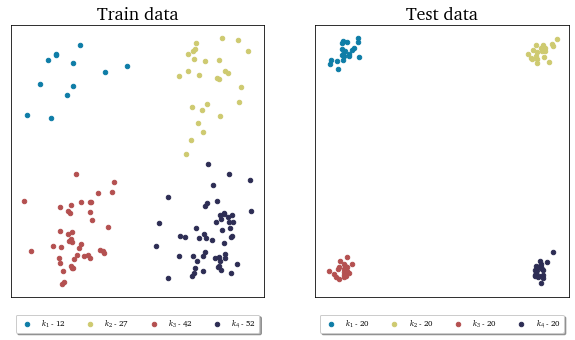

In [19]:
(idx_train, idx_test) = sample.manual({0:10, 1:10, 2:10, 3:10}, sampling_type='percentage', test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-manual-with-idx-test.svg'
preprocess.plot_2d_train_test_samples(xt, yt, idx_appended, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Cluster 0: taking 86 train samples out of 120 observations (71.7%).
Cluster 1: taking 211 train samples out of 270 observations (78.1%).
Cluster 2: taking 347 train samples out of 420 observations (82.6%).
Cluster 3: taking 420 train samples out of 520 observations (80.8%).

Cluster 0: taking 20 test samples out of 34 remaining observations (58.8%).
Cluster 1: taking 20 test samples out of 59 remaining observations (33.9%).
Cluster 2: taking 20 test samples out of 73 remaining observations (27.4%).
Cluster 3: taking 20 test samples out of 100 remaining observations (20.0%).

Selected 1064 train samples (80.0%) and 80 test samples (6.0%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

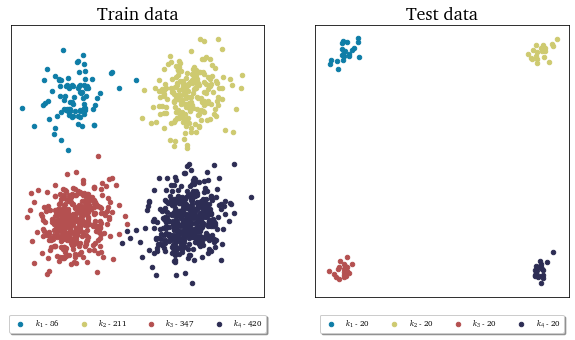

In [20]:
(idx_train, idx_test) = sample.random(80, test_selection_option=2)
if save_plots: save_filename = '../images/tutorial-train-test-select-random-with-idx-test-doc.svg'
preprocess.plot_2d_train_test_samples(xt, yt, idx_appended, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

***
<a id='chaining_sampling_functions'></a>
## Chaining sampling functions

[**Go up**](#header)

Finally, we will discuss an interesting use-case for chaining two sampling functions where train samples obtained from one sampling can become fixed test data for another sampling.

Suppose that our target is to have a fixed test data set that will be composed of:

- 10 samples from the first cluster
- 20 samples from the second cluster
- 10 samples from the third cluster
- 50 samples from the fourth cluster

and at the same time generate fixed number of samples from each cluster as train data.

We can start with generating desired test samples using `DataSampler.manual` function. We can output train data as test data:

In [21]:
sample = DataSampler(idx, random_seed=random_seed, verbose=True)
(idx_test, _) = sample.manual({0:10, 1:20, 2:10, 3:50}, sampling_type='number', test_selection_option=1)

Cluster 0: taking 10 train samples out of 100 observations (10.0%).
Cluster 1: taking 20 train samples out of 250 observations (8.0%).
Cluster 2: taking 10 train samples out of 400 observations (2.5%).
Cluster 3: taking 50 train samples out of 500 observations (10.0%).

Cluster 0: taking 90 test samples out of 90 remaining observations (100.0%).
Cluster 1: taking 230 test samples out of 230 remaining observations (100.0%).
Cluster 2: taking 390 test samples out of 390 remaining observations (100.0%).
Cluster 3: taking 450 test samples out of 450 remaining observations (100.0%).

Selected 90 train samples (7.2%) and 1160 test samples (92.8%).



Now we feed the obtained test set as a fixed test set for the target sampling:

User defined test samples will be used. Parameter `test_selection_option` will be ignored.

Cluster 0: taking 60 train samples out of 100 observations (60.0%).
Cluster 1: taking 60 train samples out of 250 observations (24.0%).
Cluster 2: taking 60 train samples out of 400 observations (15.0%).
Cluster 3: taking 60 train samples out of 500 observations (12.0%).

Cluster 0: taking 10 test samples out of 40 remaining observations (25.0%).
Cluster 1: taking 20 test samples out of 190 remaining observations (10.5%).
Cluster 2: taking 10 test samples out of 340 remaining observations (2.9%).
Cluster 3: taking 50 test samples out of 440 remaining observations (11.4%).

Selected 240 train samples (19.2%) and 90 test samples (7.2%).



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

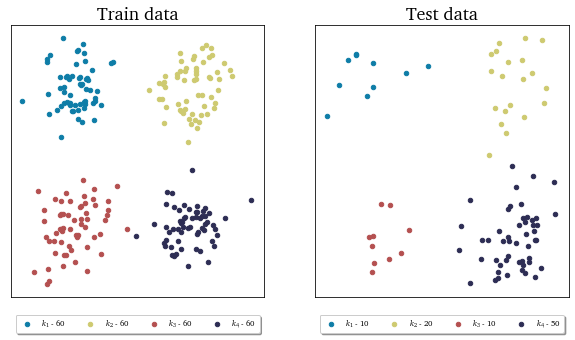

In [22]:
sample.idx_test = idx_test
(idx_train, idx_test) = sample.number(19.5, test_selection_option=1)
if save_plots: save_filename = '../images/tutorial-train-test-select-chaining-functions.svg'
preprocess.plot_2d_train_test_samples(x, y, idx, idx_train, idx_test, color_map=color_map, first_cluster_index_zero=first_cluster, figure_size=(10,5), save_filename=save_filename)

Notice that we have achieved what we wanted to: we generated a desired test data set and we also have fixed number of train samples.

***